In [ ]:
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

# Text Analysis through Natural Language Processing, Understanding and Classification

In [15]:
#Importing NLP packages
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string
import re
import pyLDAvis
import pandas as pd # to dataframes
import numpy as np #to math

In [2]:
df_description_clean=pd.read_excel('../CannaConnect/Dataset/description_clean.xlsx')
df_description_clean=df_description_clean.Description.astype(str)
df_description_clean.head()

0     og   hybrid strain pack strong punch name sup...
1     aloha white widow especially potent cut white...
2     sativa dominant hybrid bred spain medical see...
3     dawgs hybrid g chemdawg genetics bred canadia...
4    known kosher tangie k gold  indica dominant hy...
Name: Description, dtype: object

# Advance text processing

In [3]:
#N-grams of the first Description, Bi-gram and tri-gram
bi_gram = TextBlob(df_description_clean[0]).ngrams(2)
tri_gram = TextBlob(df_description_clean[0]).ngrams(3)
print(bi_gram)
print(tri_gram)

[WordList(['og', 'hybrid']), WordList(['hybrid', 'strain']), WordList(['strain', 'pack']), WordList(['pack', 'strong']), WordList(['strong', 'punch']), WordList(['punch', 'name']), WordList(['name', 'supposedly']), WordList(['supposedly', 'refers']), WordList(['refers', 'strength']), WordList(['strength', 'high']), WordList(['high', 'price']), WordList(['price', 'first']), WordList(['first', 'started']), WordList(['started', 'showing']), WordList(['showing', 'hollywood']), WordList(['hollywood', 'plant']), WordList(['plant', 'og']), WordList(['og', 'tends']), WordList(['tends', 'produce']), WordList(['produce', 'large']), WordList(['large', 'dark']), WordList(['dark', 'green']), WordList(['green', 'bud']), WordList(['bud', 'stem']), WordList(['stem', 'user']), WordList(['user', 'report']), WordList(['report', 'strong']), WordList(['strong', 'body']), WordList(['body', 'effect']), WordList(['effect', 'indica']), WordList(['indica', 'pain']), WordList(['pain', 'relief']), WordList(['reli

In [4]:
#Term frequency of Description
tf1 = df_description_clean.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
print(tf1.head())

        words      tf
0              2419.0
1      strong   333.0
2          og  1051.0
3     feeling    78.0
4  supposedly    17.0


In [5]:
#Inverse Document Frequency of Description
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(df_description_clean.shape[0]/(len(df_description_clean[df_description_clean.str.contains(word)])))
print(tf1.head())

        words      tf       idf
0              2419.0  0.000000
1      strong   333.0  1.962652
2          og  1051.0  1.316025
3     feeling    78.0  3.431012
4  supposedly    17.0  4.928532


In [6]:
#Term Frequency – Inverse Document Frequency (TF-IDF) of Description
tf1['tfidf'] = tf1['tf'] * tf1['idf']
print(tf1.head())

        words      tf       idf        tfidf
0              2419.0  0.000000     0.000000
1      strong   333.0  1.962652   653.563226
2          og  1051.0  1.316025  1383.142449
3     feeling    78.0  3.431012   267.618908
4  supposedly    17.0  4.928532    83.785038


In [7]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(df_description_clean)
train_vect

<2349x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 71263 stored elements in Compressed Sparse Row format>

In [8]:
#Bag of Words
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(df_description_clean)
train_bow

<2349x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 74552 stored elements in Compressed Sparse Row format>

In [9]:
#LSA analysis
tfidf = TfidfVectorizer(strip_accents='ascii', lowercase=True, max_df=0.90, max_features=1000, min_df=0.1,  analyzer='word', stop_words= 'english', ngram_range=[1,3])
%time train_vect = tfidf.fit_transform(df_description_clean)
train_vect.shape

Wall time: 596 ms


(2349, 63)

In [12]:
svd_model = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(train_vect)
len(svd_model.components_)

3

In [13]:
#LSA - part 2
terms = tfidf.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:3]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        #print(" ")

Topic 0: 
strain
indica
effect
Topic 1: 
og
kush
indica
Topic 2: 
purple
indica
indica dominant


C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


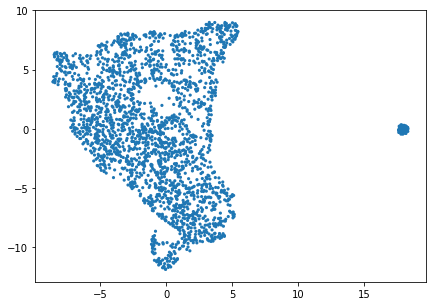

In [18]:
import umap

X_topics = svd_model.fit_transform(train_vect)
embedding = umap.UMAP(n_neighbors=15, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
s = 10, # size
edgecolor='none'
)
plt.show()